# Modelado en Optimización (IIND-2501)

## Lección 3.1.2: Optimización en problemas de estimación

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Evitar problemas de estilo/versión
np.set_printoptions(precision=4, suppress=True)
plt.rcParams["figure.figsize"] = (6,4)

### 1 - Formular un problema de estimación con datos sintéticos  

Creamos un dataset sencillo con una sola variable para poder visualizar el comportamiento de los métodos de optimización que resuelven problemas de aprendizaje. Suponemos una variable $y$ cuyo comportamiento se relaciona con otra variable $x$ de forma lineal. Por ejemplo, en determinado sector, el salario de una persona ($y$) puede depender linealmente de sus años de experiencia ($x$). 

$$\mathbf{y} = a + b\mathbf{x}$$

Con suficientes observaciones, podemos determinar si esto en efecto se cumple, y cuál sería la recta que nos ayuda a explicar o predecir los salarios en este sector a partir de los años de experiencia de un aspirante (i.e., qué valores de $a$ y $b$ generan buenas estimaciones de $y$ a partir de $x$).

In [2]:
np.random.seed(42)

# Datos sintéticos
a_true, b_true = 8, 4
n = 80
x = np.random.uniform(0, 20, n)
noise = np.random.normal(0, 3, n)

# Creación X y Y
y = (a_true + b_true * x) + noise
X = np.vstack([np.ones(n), x]).T

display( pd.DataFrame({"Años de experiencia (x)":[round(i,1) for i in x], "Salario normalizado (y)":[round(i,1) for i in y]}).head() )

,Años de experiencia (x),Salario normalizado (y)
0,7.5,39.0
1,19.0,87.0
2,14.6,65.1
3,12.0,55.3
4,3.1,17.2


In [3]:
def show_guess(a=0.0, b=1.0, max_lines=100):
    y_hat = a + b * x    
    mse = np.mean((y - y_hat)**2)   
    
    plt.figure(figsize=(5,3))
    plt.scatter(x, y, alpha=0.6, label="datos")    
    plt.plot(x, y_hat, color="crimson", lw=1, label=f"y = {a:.1f} + {b:.1f}x")    
    
    idx = np.arange(len(x))
    if max_lines < len(x):
        rng = np.random.default_rng(0)
        idx = rng.choice(idx, size=max_lines, replace=False)
    for i in idx:
        plt.plot([x[i], x[i]], [y[i], y_hat[i]],
                 ls="--", lw=0.6, color="gray", alpha=0.7)
        
    plt.title("Ajuste manual de la recta"); plt.xlabel("x"); plt.ylabel("y")
    plt.legend(); plt.show()
    print(f"La recta __ y = {a:.1f} + {b:.1f}x __ produce un ERROR de {mse:.1f}\n\n")

a_slider = widgets.FloatSlider(min=-2, max=50, step=0.1, value=0,
                               description="a", continuous_update=False)
b_slider = widgets.FloatSlider(min=-2, max=10, step=0.1, value=1,
                               description="b", continuous_update=False)

ui = widgets.HBox([a_slider, b_slider])
out = widgets.interactive_output(show_guess, {'a': a_slider, 'b': b_slider})
display(ui, out)

Output()

### 2 - Definir cómo medir qué tan bueno es el modelo de estimación

Para unos valores dados, $a'$ y $b'$, podemos hacer una estimación de $y$ dado un $x$ conocido.

$$\hat{y}=a' + b' x$$

La distancia entre $\hat{y}$ y el $y$ real de las observaciones nos da una idea de qué tan buena es la estimación lineal que logran $a'$ y $b'$. Queremos los valores de $a$ y $b$ que minimizan esa distancia, comunmente medida a través del *Error Medio Cuadrático* (MSE) o algunas variaciones.

$$MSE = \frac{1}{N}\sum_{i=1}^{N}[ y_i-\hat{y}_i ]^2$$

$$MSE = \frac{1}{N}\sum_{i=1}^{N}[y_i-(a+b x_i)]^2 = f(a,b)$$

Es decir, queremos la recta que se ajusta más cercanamente a las observaciones disponibles, así que formulamos el siguiente problema de optimización: *¿qué valores de a y b minimizan el MSE?*.

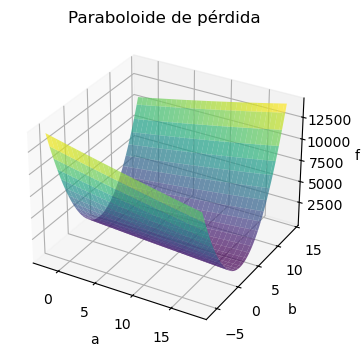

In [4]:
def mse(beta0, beta1):
    beta = np.array([beta0, beta1])
    res = y - X @ beta
    return (res @ res) / n

b0 = np.linspace(a_true-10, a_true+10, 60)
b1 = np.linspace(b_true-10, b_true+10, 60)
B0, B1 = np.meshgrid(b0, b1)
J = np.vectorize(mse)(B0, B1)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(B0, B1, J, cmap='viridis', alpha=0.7)
ax.set_xlabel('a'); ax.set_ylabel('b'); ax.set_zlabel('f')
plt.title('Paraboloide de pérdida'); plt.show()

### 3 – Solución analítica mediante álgebra lineal

De manera general, se le llama $\theta$ o $\beta$ al vector que agrupa los coeficientes de la relación lineal entre $x$ y $y$ (es decir, los coeficiente $a$ y $b$, y otros cuando se incluyen más variables). Así, con $\mathbf{\beta}=[\beta_0, \beta_1]$, tendríamos:

$$y = \beta_0 + \beta_1 x$$

Y de manera general, $y = \mathbf{\beta}X$. Una manera formal de escribir algebraicamente el MSE es a través de la norma del vector diferencia entre el $y$ real y el $y$ estimado ($\mathbf{\beta}X$):

$$J(\beta) = \|y - X\beta\|_2^2$$

Por tratarse de una función cuadrática, sabemos que el mínimo estará en el punto donde "la derivada" se hace cero, lo cual se extiende al concepto de gradiente y se conoce como *condiciones de primer orden* (el óptimo deberá cumplir $\nabla J = 0$):

$$ -2X^\top(y - X\beta)=0$$
$$ (X^\top X)\beta = X^\top y$$
$$\hat\beta=(X^\top X)^{-1}X^\top y$$

In [5]:
beta_closed = np.linalg.inv(X.T @ X) @ (X.T @ y)
print('Valores estimados analíticamente\n [a,b] = [beta_0, beta_1] =', beta_closed)

Valores estimados analíticamente
 [a,b] = [beta_0, beta_1] = [7.3434 4.0674]


### 4 – Solución iterativa mediante *descenso de gradiente*

Para la misma $J(\beta)$, su gradiente es
$$\nabla J(\beta) = -\frac{2}{n} X^\top (y - X\beta).$$

Partiremos de un punto arbitrario $x_0$ y aplicaremos la ecuación de actualización de movimiento, usando siempre como dirección el gradiente negativo en el punto (i.e., $\Delta x = \nabla J(\beta)$), y variando diferentes tamaños de paso $\alpha$.

$$\mathbf{x}_{t+1} = \mathbf{x}_t + \alpha \Delta \mathbf{x}$$

In [6]:
def gradient_descent(X, y, alpha=0.001, max_iter=5000, tol=1e-6):
    n, p = X.shape
    beta = np.ones(p)
    traj_beta = [beta.copy()]
    traj_J = []
    for it in range(max_iter):
        res = y - X @ beta
        grad = -(2/n) * X.T @ res
        beta_new = beta - alpha * grad
        traj_beta.append(beta_new.copy())
        traj_J.append((res @ res)/n)
        if np.linalg.norm(beta_new - beta) < tol:
            break
        beta = beta_new
    return beta, np.array(traj_beta), traj_J

beta_gd, traj_b, traj_J = gradient_descent(X, y)
print('Beta GD:', beta_gd)

Beta GD: [7.0307 4.091 ]


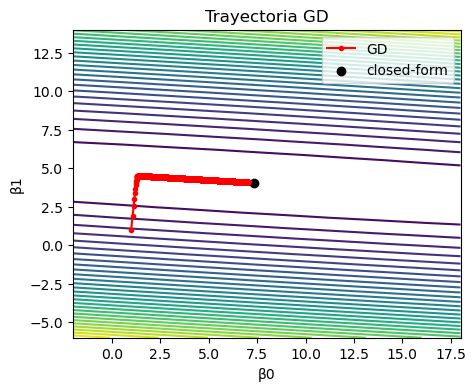

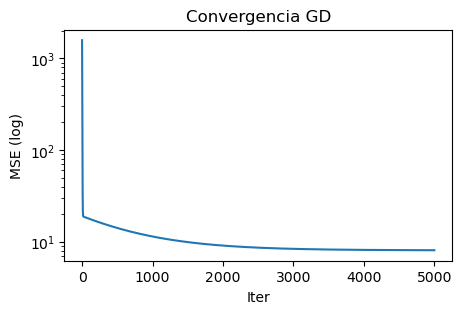

In [7]:
plt.figure(figsize=(5,4))
plt.contour(B0, B1, J, levels=30, cmap='viridis')
plt.plot(traj_b[:,0], traj_b[:,1], 'r.-', label='GD')
plt.scatter(beta_closed[0], beta_closed[1], c='black', label='closed‑form')
plt.xlabel('β0'); plt.ylabel('β1'); plt.title('Trayectoria GD'); plt.legend(); plt.show()

plt.figure(figsize=(5,3))
plt.plot(traj_J); plt.yscale('log')
plt.xlabel('Iter'); plt.ylabel('MSE (log)'); plt.title('Convergencia GD'); plt.show()

### 5 - Comparación de resultados

In [8]:
DF = pd.DataFrame({'Real':[a_true, b_true], 'Analítico':beta_closed, 'Gradiente': beta_gd}, index=['a','b'])
DF

,Real,Analítico,Gradiente
a,8,7.343360,7.030710
b,4,4.067411,4.091011


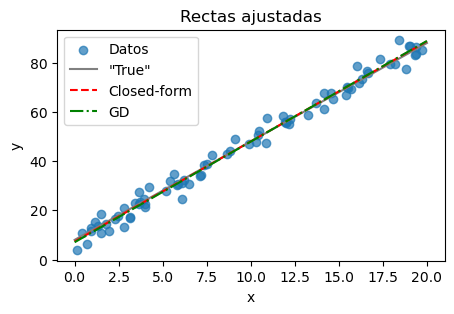

In [9]:
def plot_regression(x, y, beta_closed, beta_gd):
    plt.figure(figsize=(5,3))
    plt.scatter(x, y, alpha=0.7, label='Datos')
    xs = np.linspace(0, 20, 100)
    plt.plot(xs, a_true + b_true*xs, color='gray', label='"True"')
    plt.plot(xs, beta_closed[0] + beta_closed[1]*xs, '--', color='r', label='Closed‑form')
    plt.plot(xs, beta_gd[0] + beta_gd[1]*xs, '-.', color='g', label='GD')
    plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.title('Rectas ajustadas')
    plt.show()

plot_regression(x, y, beta_closed, beta_gd)

### 6 - Ejemplo con datos reales (regresión lineal)

Usaremos un dataset **real** disponible públicamente (sin autenticación) y mantendremos el caso sintético como guía.
El objetivo es **predecir una variable continua** (p.ej., `body_mass_g`) a partir de rasgos (`flipper_length_mm`, `bill_length_mm`).


Intercepto: -5535.790489996305
Coeficientes [flipper_length_mm, bill_length_mm]: [47.4531  4.5274]
R^2 (test): 0.8256721849890146
RMSE (test): 351.8336963913367


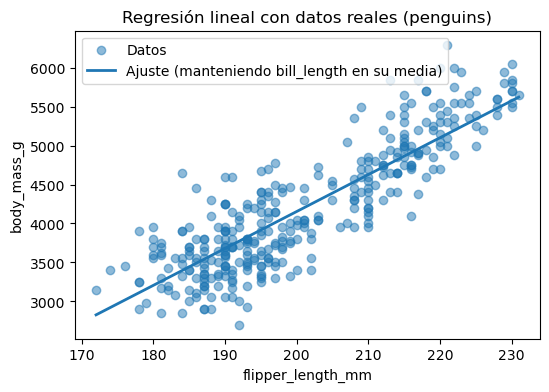

In [10]:
# ¡Ejemplo real! Penguins (seaborn): predice masa corporal a partir de rasgos
# Fuente CSV (GitHub): https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv
# Requisitos: pandas, numpy, scikit-learn, matplotlib

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
peng = pd.read_csv(url)
# Limpieza mínima
peng = peng.dropna(subset=["body_mass_g","flipper_length_mm","bill_length_mm"])

X = peng[["flipper_length_mm","bill_length_mm"]].values
y = peng["body_mass_g"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Intercepto:", model.intercept_)
print("Coeficientes [flipper_length_mm, bill_length_mm]:", model.coef_)
print("R^2 (test):", r2_score(y_test, y_pred))
print("RMSE (test):", mean_squared_error(y_test, y_pred, squared=False))

# Visualización 2D simple: relación con longitud de aleta (manteniendo el otro rasgo en su media)
fl = np.linspace(peng["flipper_length_mm"].min(), peng["flipper_length_mm"].max(), 50)
bl_mean = np.full_like(fl, peng["bill_length_mm"].mean())
X_line = np.column_stack([fl, bl_mean])
y_line = model.predict(X_line)

plt.figure()
plt.scatter(peng["flipper_length_mm"], peng["body_mass_g"], alpha=0.5, label="Datos")
plt.plot(fl, y_line, linewidth=2, label="Ajuste (manteniendo bill_length en su media)")
plt.xlabel("flipper_length_mm")
plt.ylabel("body_mass_g")
plt.legend()
plt.title("Regresión lineal con datos reales (penguins)")
plt.show()

# TODO (para estudiantes): Repite usando otra combinación de rasgos / dataset real, reporta R^2 y RMSE.
